##### Purpose of the notebook ####

Explore gene modules present within different cell types, defining subtypes. In this case: oligodendrocytes.

In [ ]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

# Format Xenium data to anndata

In [2]:
files=['/media/sergio/GBX/xenium_prerelease_nov23_5k_v2/xenium_prerelease_nov23_5k/hKidney_FF']
output_path=r'/media/sergio/GBX/xenium_prerelease_nov23_5k_v2/pipeline_output_5000Kkidney/'
save=True ## Saving intermediate outputs
plot_path=output_path+'/figures/'

In [3]:
max_nucleus_distance=1
min_quality=0

In [4]:
adata=format_to_adata(files=files,output_path=output_path,max_nucleus_distance=max_nucleus_distance,min_quality=min_quality,save=save)

Formatting hKidney_FF


/media/sergio/xenium_b_and_heart/actual_repo/Xenium_benchmarking/xb/formatting.py:535: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata=sc.AnnData(ad.transpose(),obs=cell_info,var=features)
/home/sergio/anaconda3/envs/xb_dev3/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Filter reads


/media/sergio/xenium_b_and_heart/actual_repo/Xenium_benchmarking/xb/formatting.py:627: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata1nuc=sc.AnnData(np.array(ct1),obs=adataobs,var=av)


# CNV inference starts from here

In [3]:
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import warnings
import numpy as np

In [4]:
adata=sc.read('/media/sergio/GBX/xenium_prerelease_nov23_5k_v2/pipeline_output_5000Kkidney/combined_filtered.h5ad')

In [65]:
dat = cnv.datasets.maynard2020_3k()
dat.var.loc[:, ["ensg", "chromosome", "start", "end"]].head()

ensg chromosome      start        end
symbol                                                        
AL645933.5  ENSG00000288587.1       chr6   31400702   31463705
AC010184.1  ENSG00000288585.1       chr3  141449745  141456434
AC023296.1  ENSG00000288580.1       chr8    2923568    2926689
AL117334.2  ENSG00000288577.1      chr20    3406380    3410036
AC107294.4  ENSG00000288576.1       chr3  184778723  184780720

In [66]:
adata=adata[:,adata.var.index.isin(dat.var['gene_name'])]

In [67]:
name2gid=dict(zip(dat.var['gene_name'],dat.var['gene_id']))
name2symbol=dict(zip(dat.var['gene_name'],dat.var.index))

In [68]:
adata.var['gene_id']=adata.var.index.map(name2gid)
adata.var['symbol']=adata.var.index.map(name2symbol)

/tmp/ipykernel_10216/4285209568.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['gene_id']=adata.var.index.map(name2gid)


In [69]:
name2ensg=dict(zip(dat.var['gene_name'],dat.var['ensg']))
name2chromosome=dict(zip(dat.var['gene_name'],dat.var['chromosome']))
name2start=dict(zip(dat.var['gene_name'],dat.var['start']))
name2end=dict(zip(dat.var['gene_name'],dat.var['end']))

In [70]:
adata.var['ensg']=adata.var.index.map(name2ensg)
adata.var['chromosome']=adata.var.index.map(name2chromosome)
adata.var['start']=adata.var.index.map(name2start)
adata.var['end']=adata.var.index.map(name2end)

In [71]:
#sc.pp.subsample(adata,0.1)

In [72]:
adata.layers['raw']=adata.X.copy()

In [73]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_pcs=50)

In [74]:
sc.tl.umap(adata)

In [75]:
sc.tl.leiden(adata)

... storing 'chromosome' as categorical


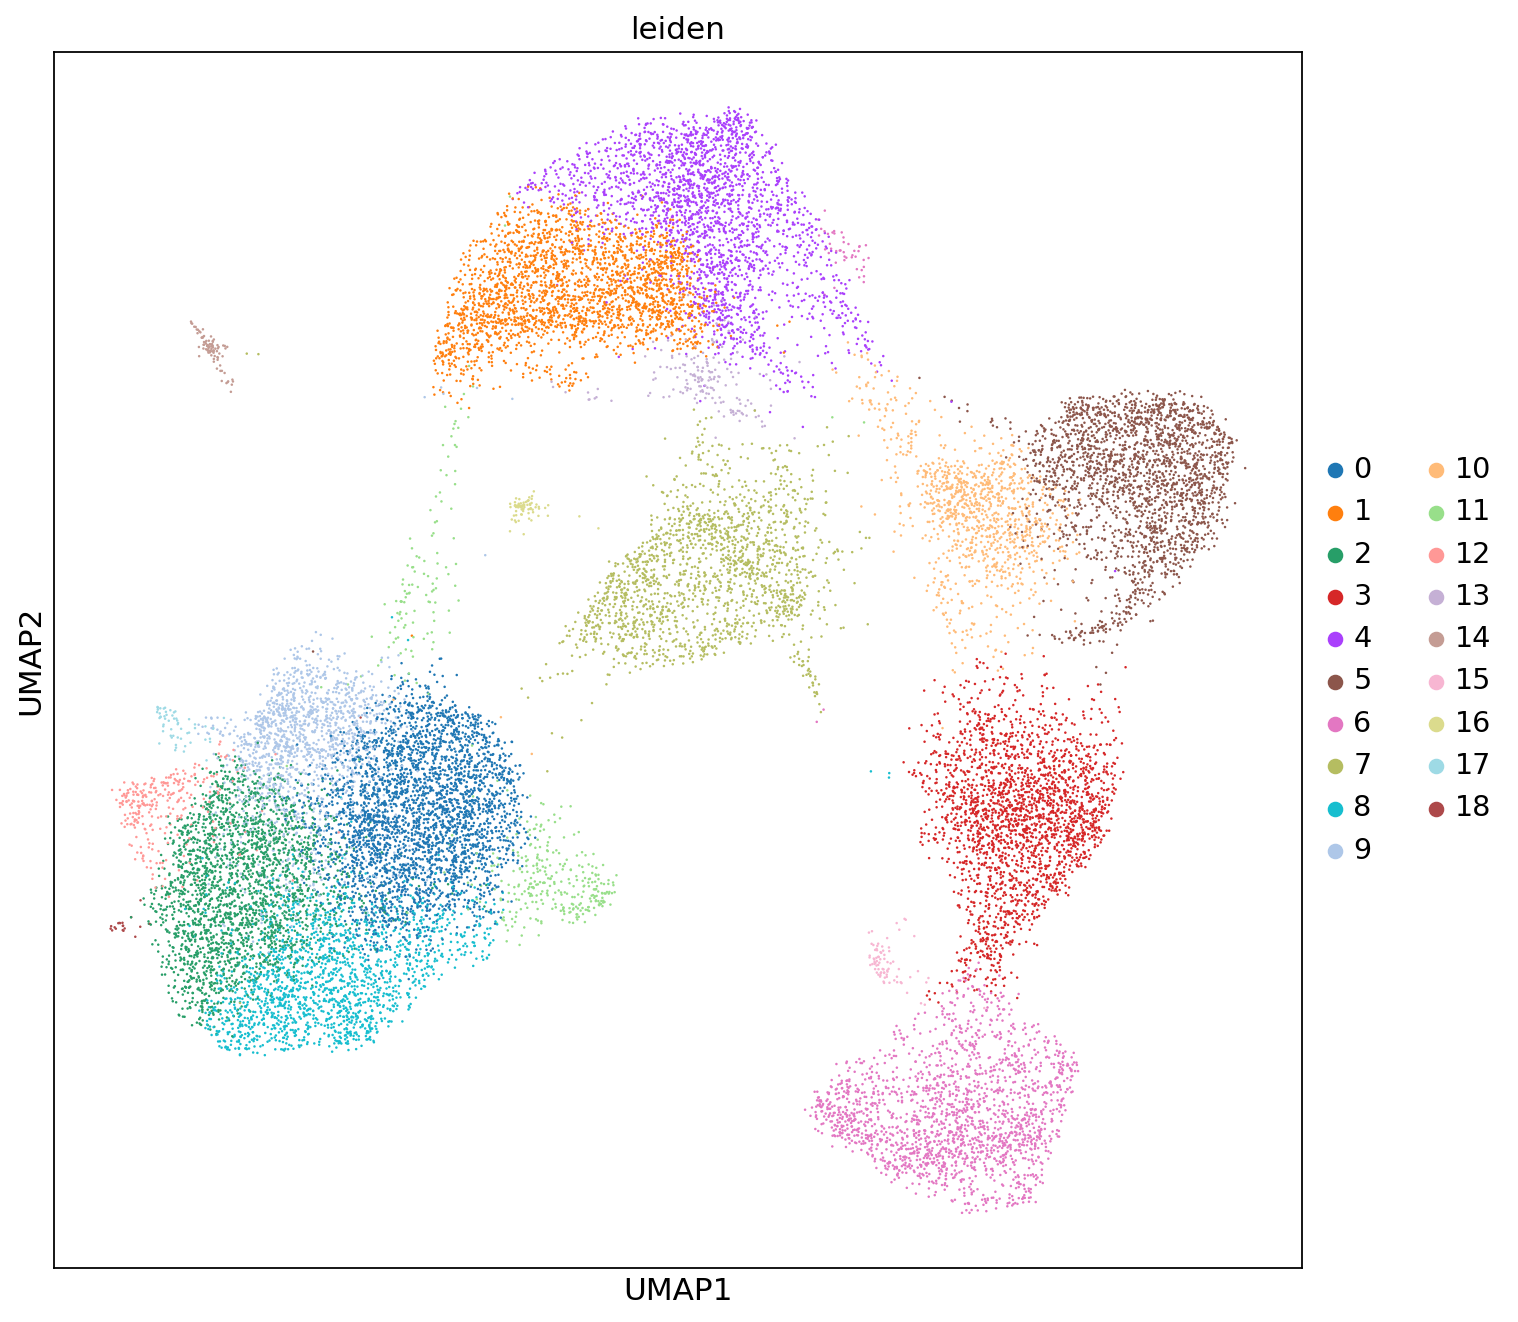

In [76]:
sc.pl.umap(adata,color='leiden')

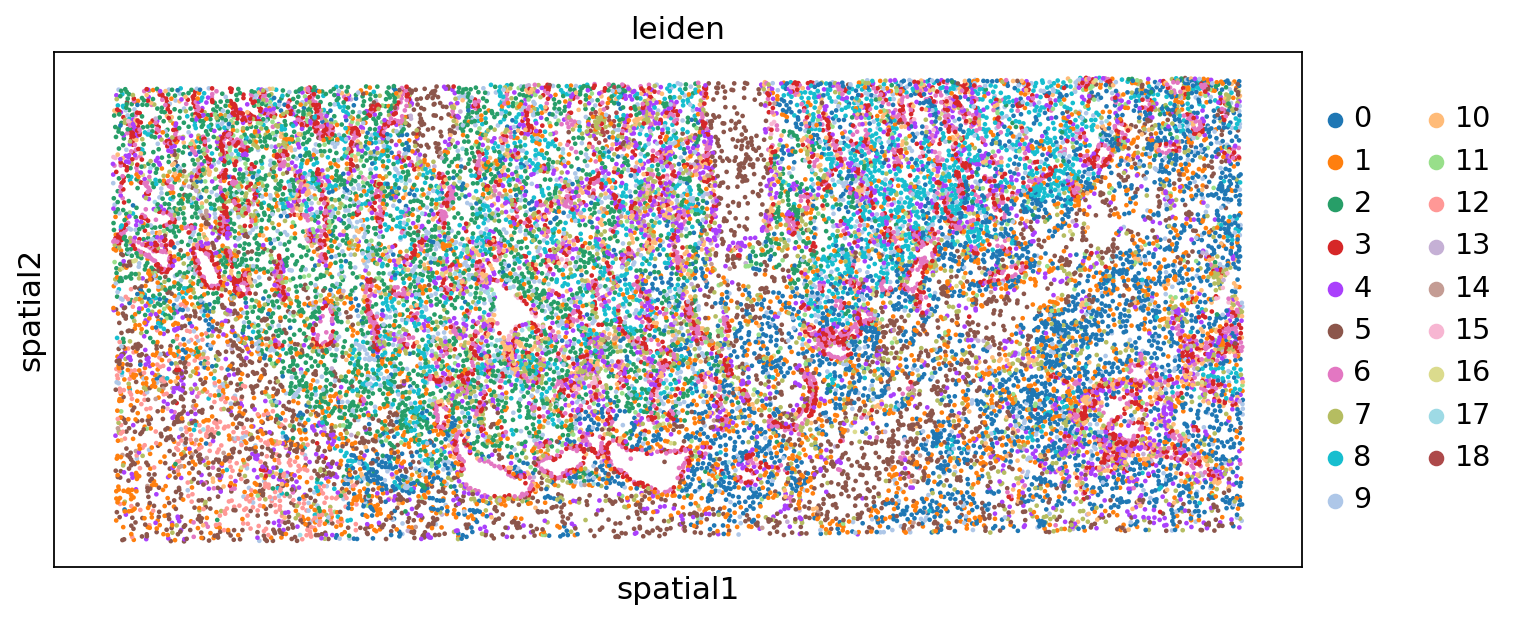

In [115]:
sc.pl.spatial(adata,color='leiden',spot_size=15)

In [78]:
import numpy as np
sc.tl.rank_genes_groups(adata,groupby='leiden')


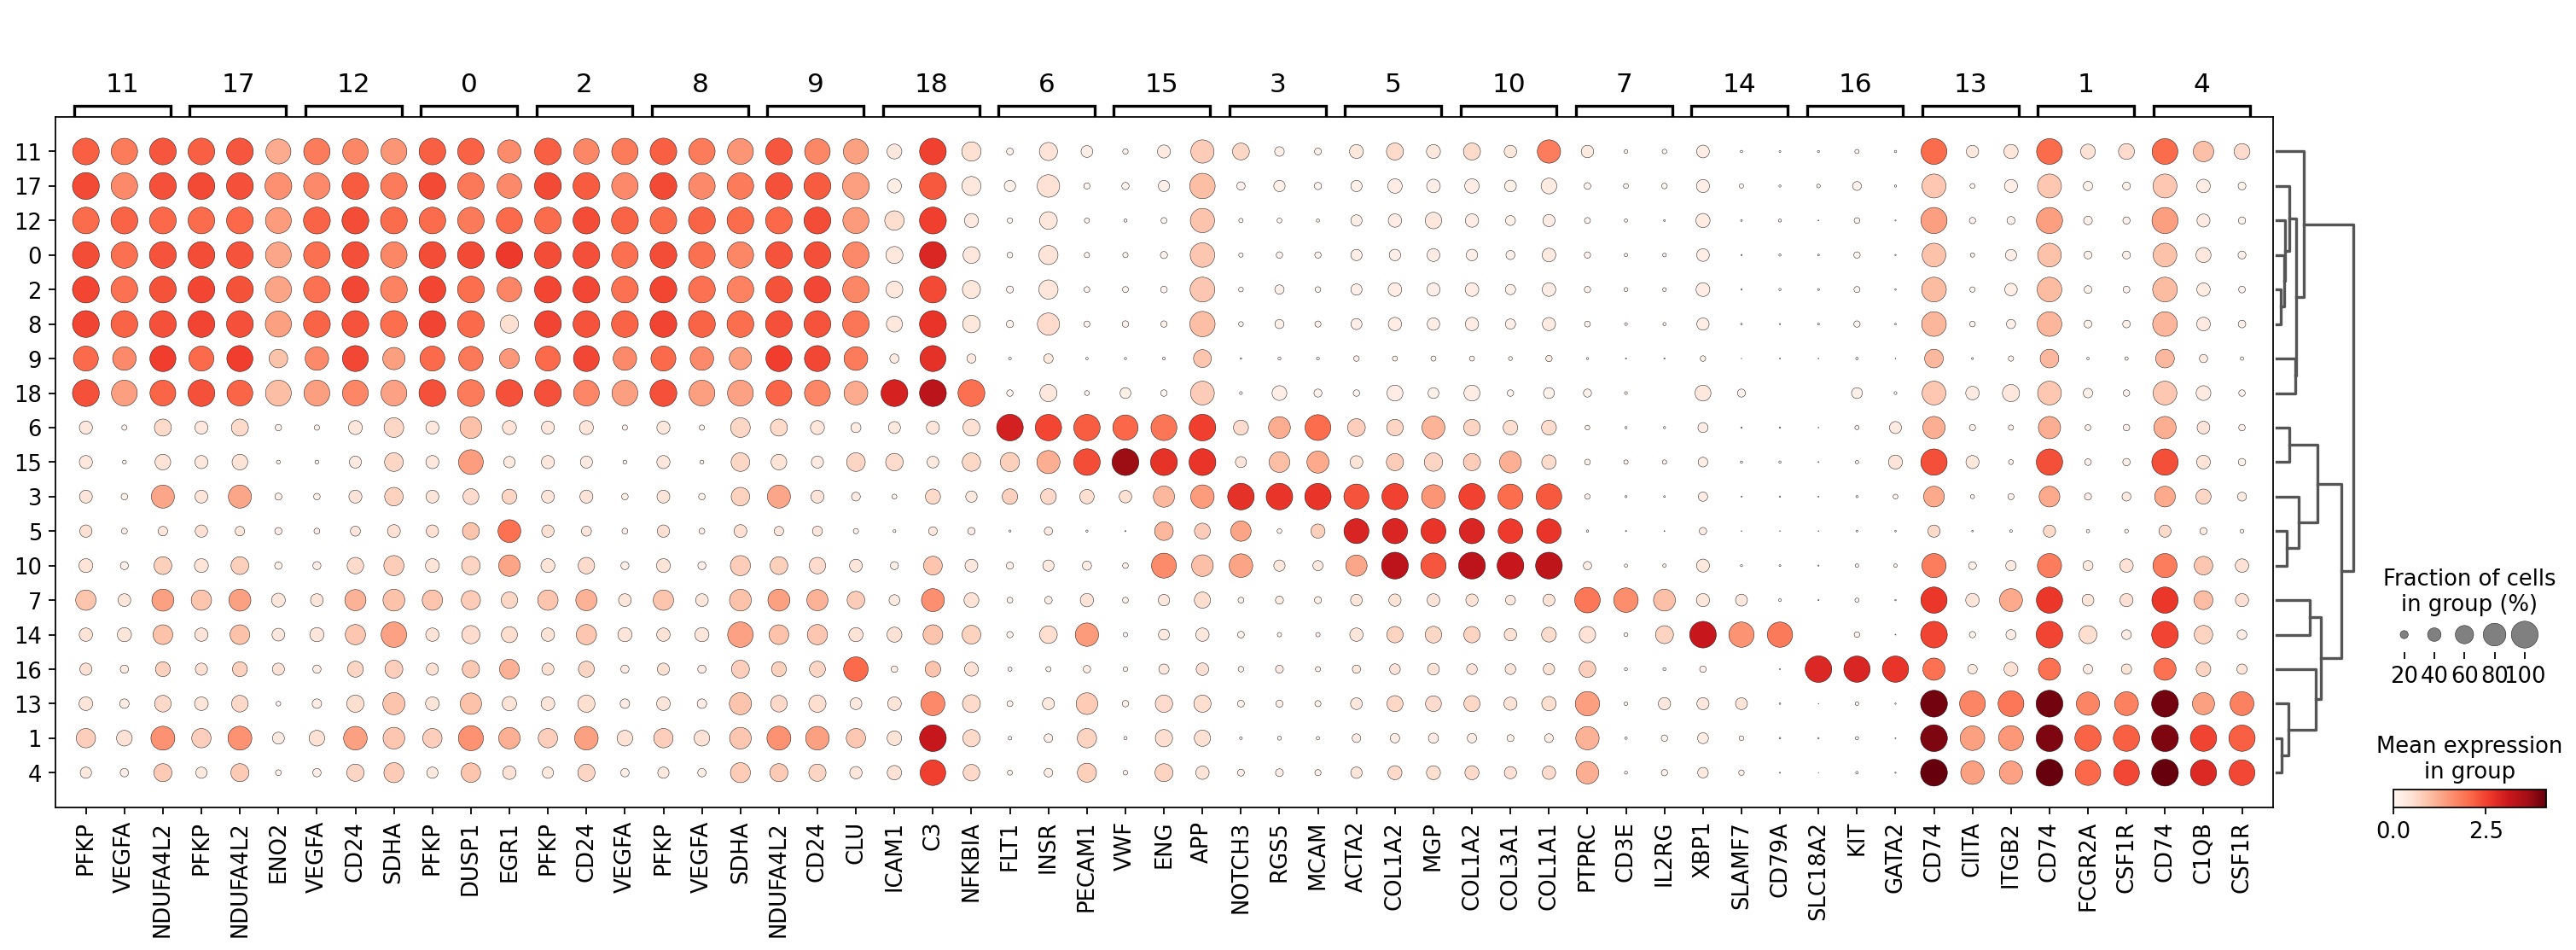

In [79]:
sc.pl.rank_genes_groups_dotplot(adata,n_genes=3)

In [109]:
adata.X=adata.layers['raw']
sc.pp.normalize_total(adata)
sc.pp.downsample_counts(adata,counts_per_cell=140)

In [110]:
sc.settings.set_figure_params(figsize=(10, 10))
# We provide all immune cell types as "normal cells".
cnv.tl.infercnv(
    adata,
    reference_key="leiden",
    reference_cat=[
    '7','6','15'],
    window_size=50,
)

/home/sergio/.local/lib/python3.8/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


  0%|          | 0/5 [00:00<?, ?it/s]

In [112]:
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [111]:
cnv.pl.chromosome_heatmap(adata, groupby="leiden")

ValueError: vmin, vcenter, and vmax must be in ascending order

categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


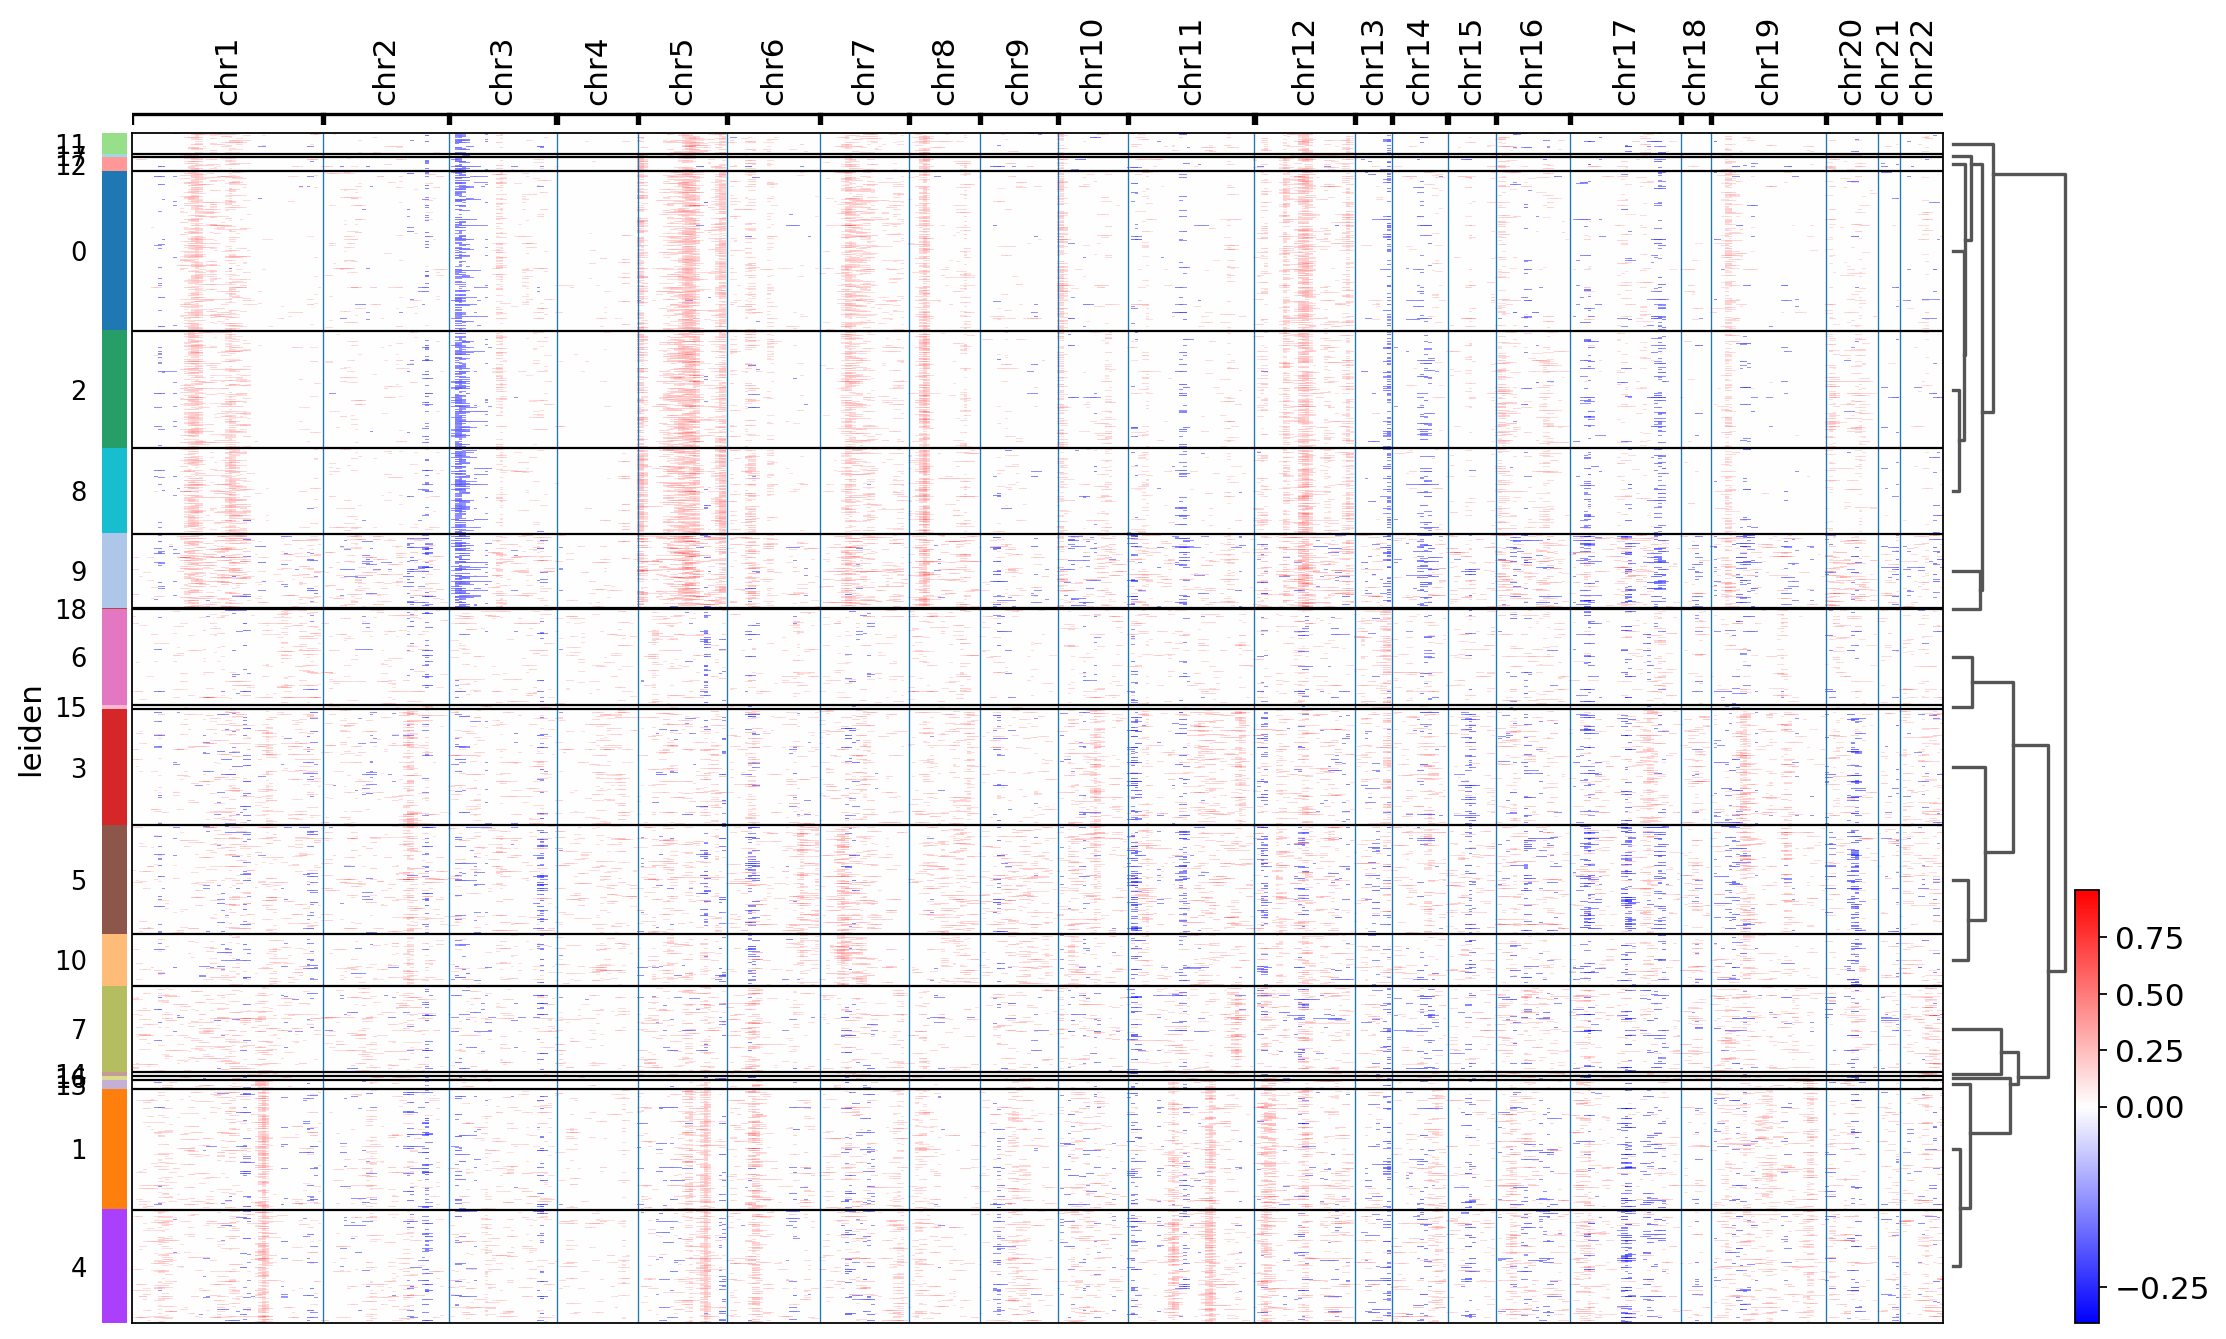

In [97]:
cnv.pl.chromosome_heatmap(adata, groupby="leiden",dendrogram=True)

In [83]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)

In [85]:
cnv.tl.leiden(adata,resolution=0.2)

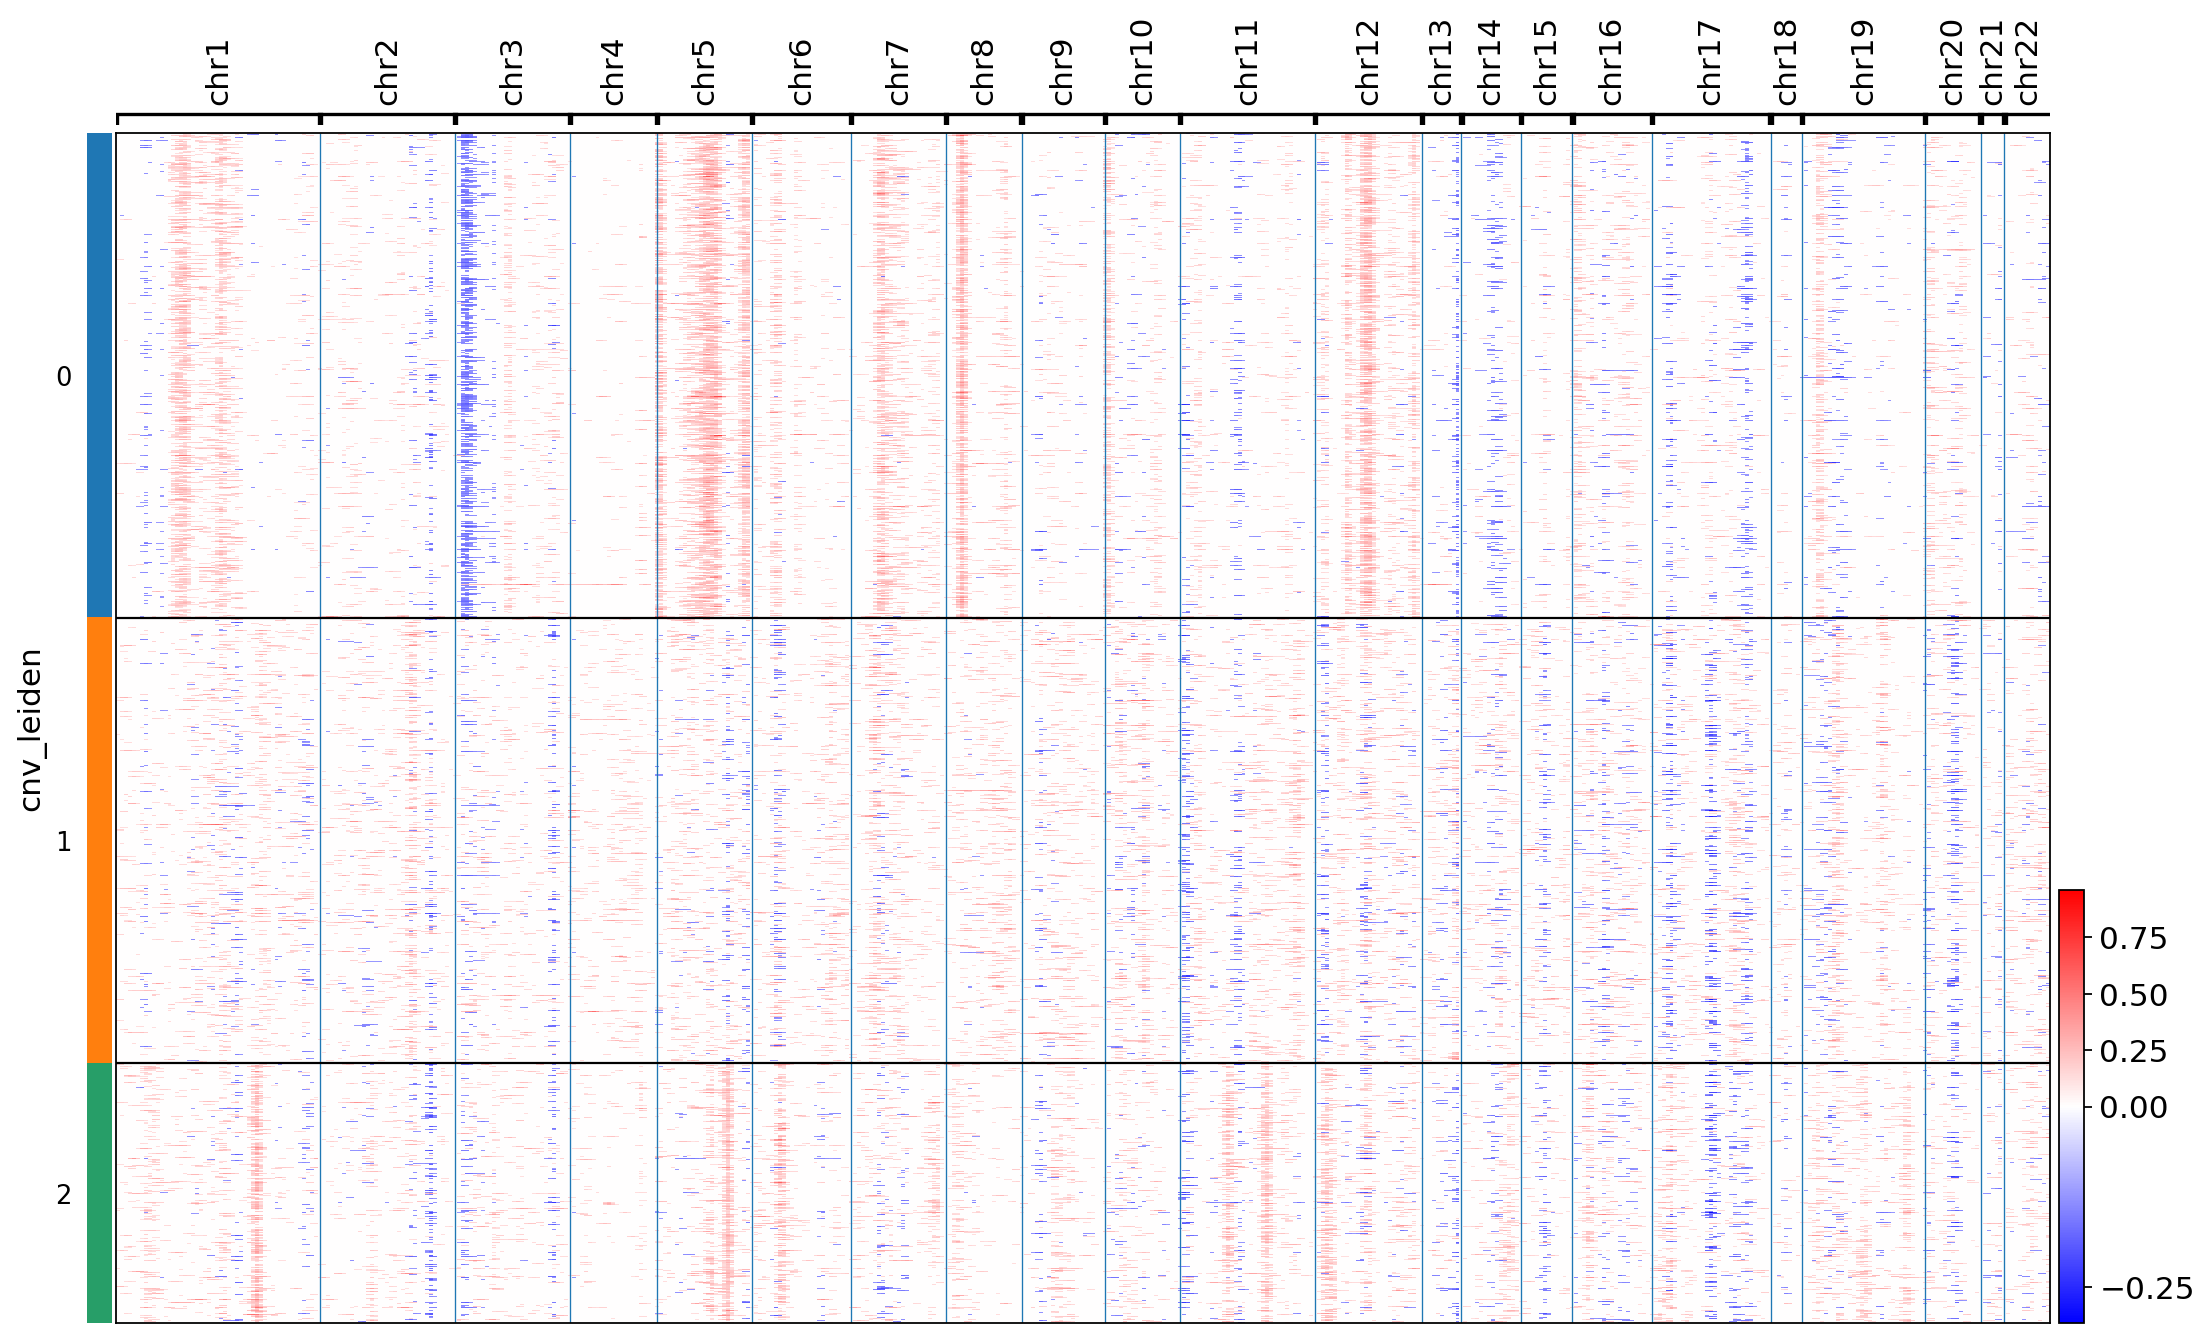

In [86]:
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=False)

In [88]:
cnv.tl.umap(adata)
cnv.tl.cnv_score(adata)

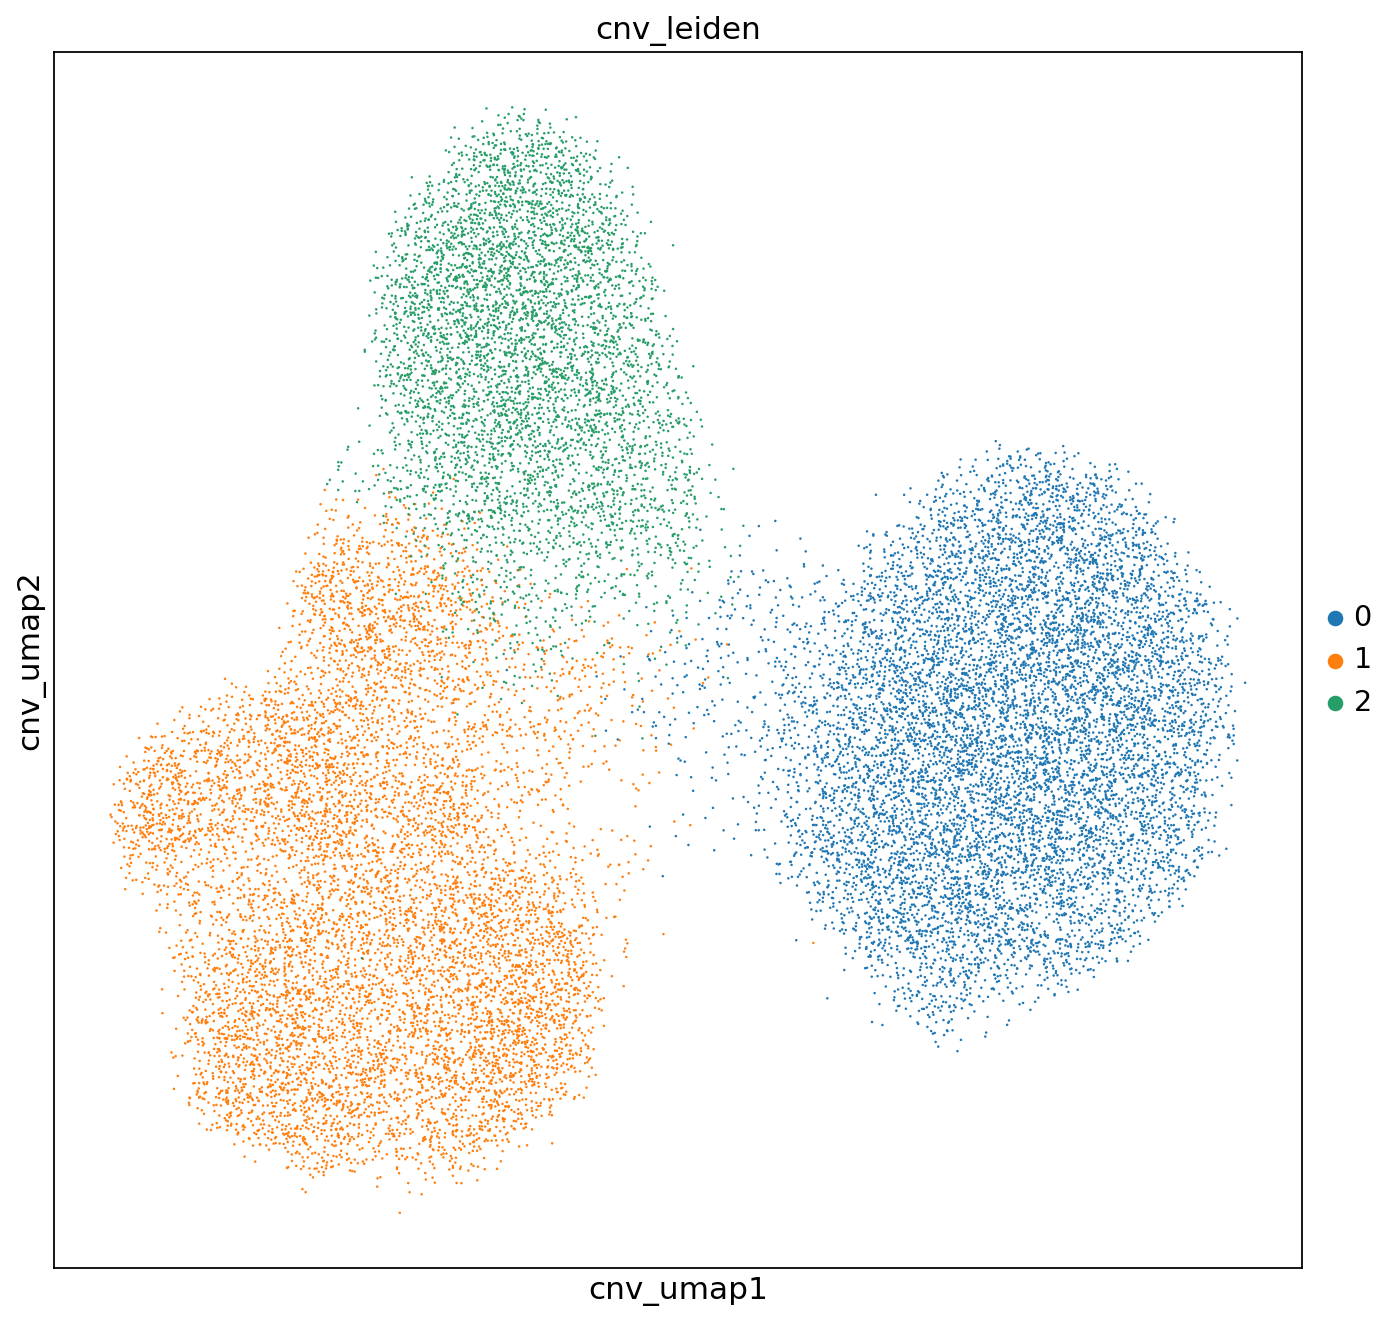

In [91]:
cnv.pl.umap(adata,color='cnv_leiden')

In [49]:
adata.obs['cnv_leiden']=adata.obs['cnv_leiden'].astype(str).astype(int)
adata.obs.loc[adata.obs['cnv_leiden']>10,'cnv_leiden']=10
adata.obs['cnv_leiden']=adata.obs['cnv_leiden'].astype(str).astype(str)
del adata.uns['cnv_leiden_colors']

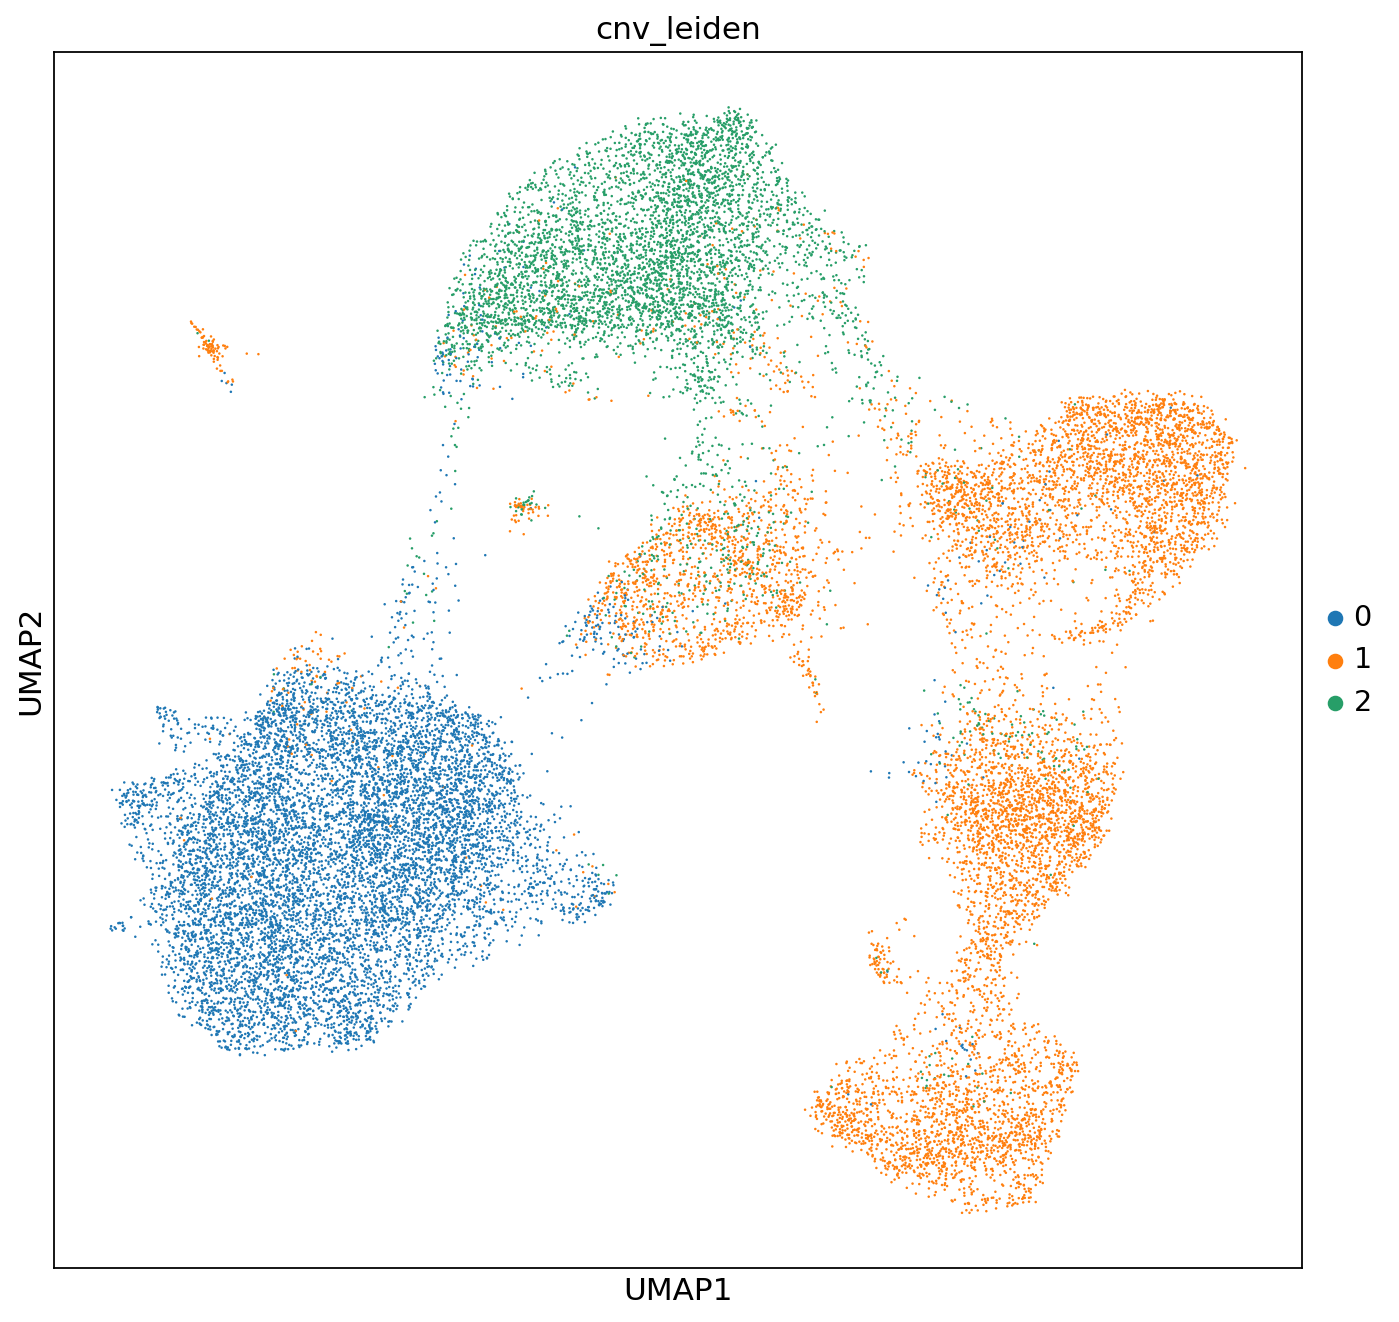

In [92]:
sc.settings.set_figure_params(figsize=(10, 10))
sc.pl.umap(
    adata,color="cnv_leiden",
    legend_fontoutline=2,cmap='tab20'
)

In [55]:
adata.obs['cnv_score']=adata.obs['cnv_score'].astype(float)

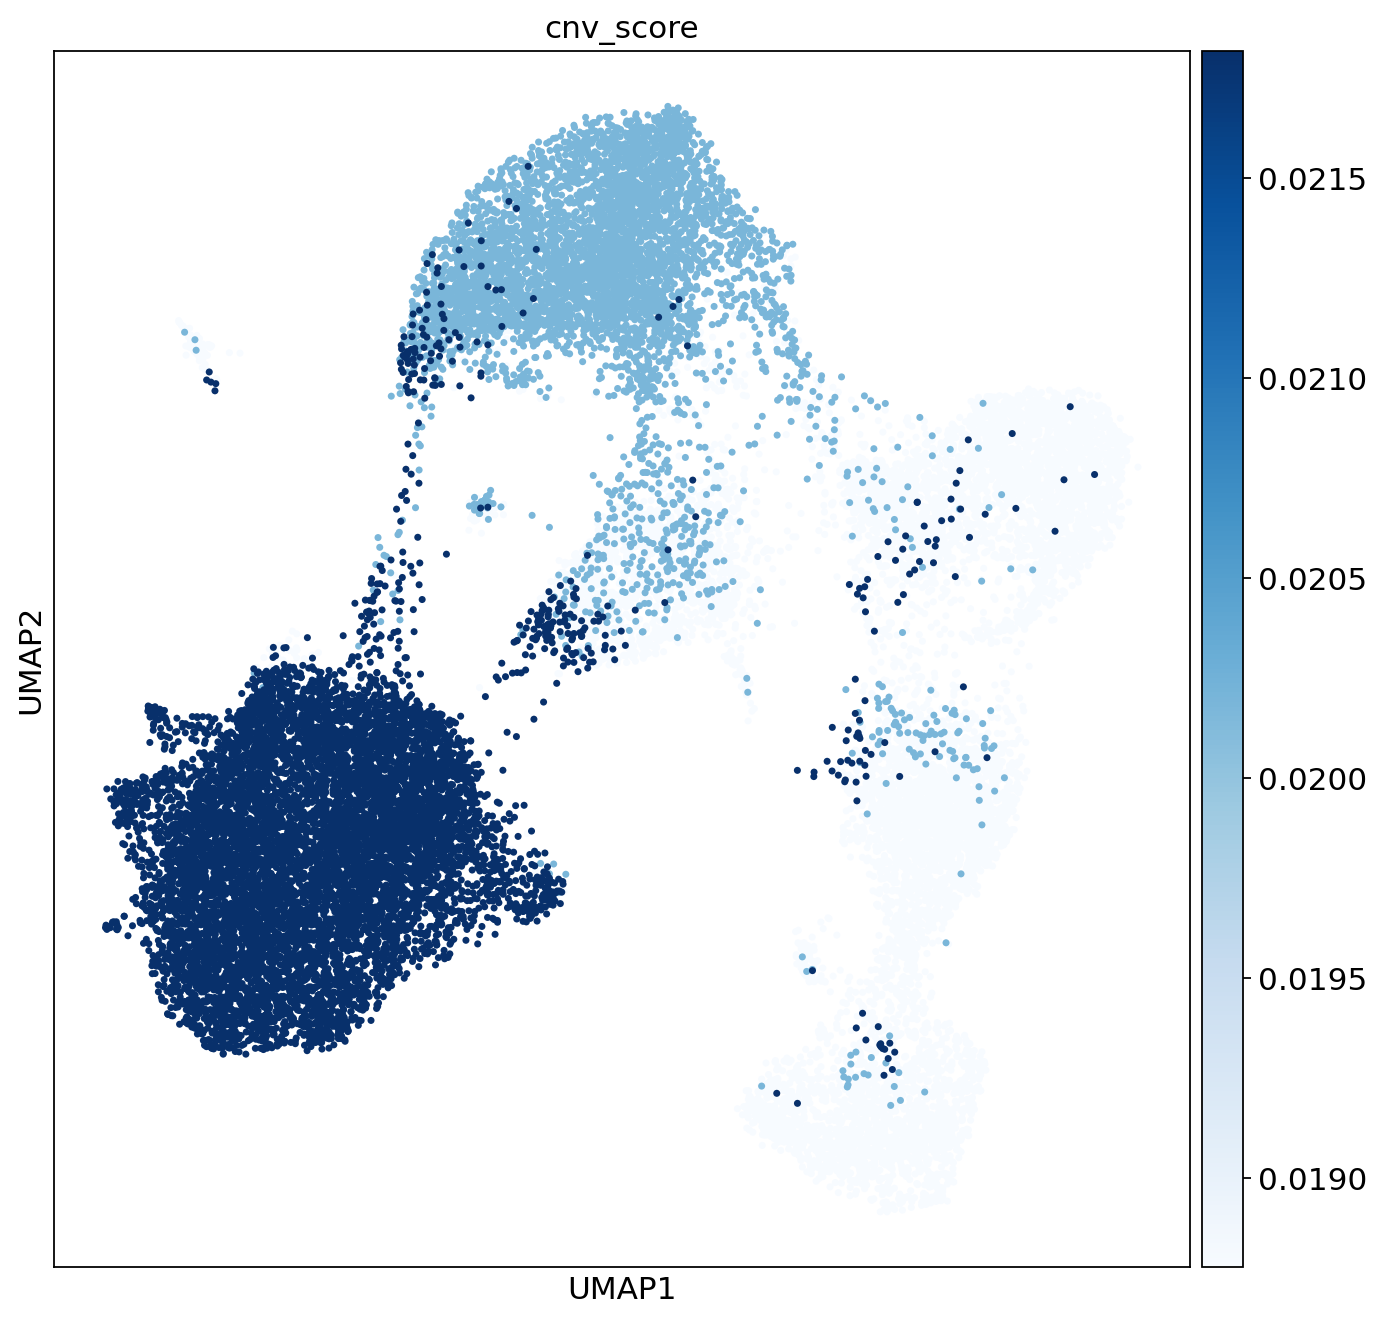

In [93]:
sc.settings.set_figure_params(figsize=(10, 10))
sc.pl.umap(
    adata,color="cnv_score",
    legend_fontoutline=2,cmap='Blues',s=40
)

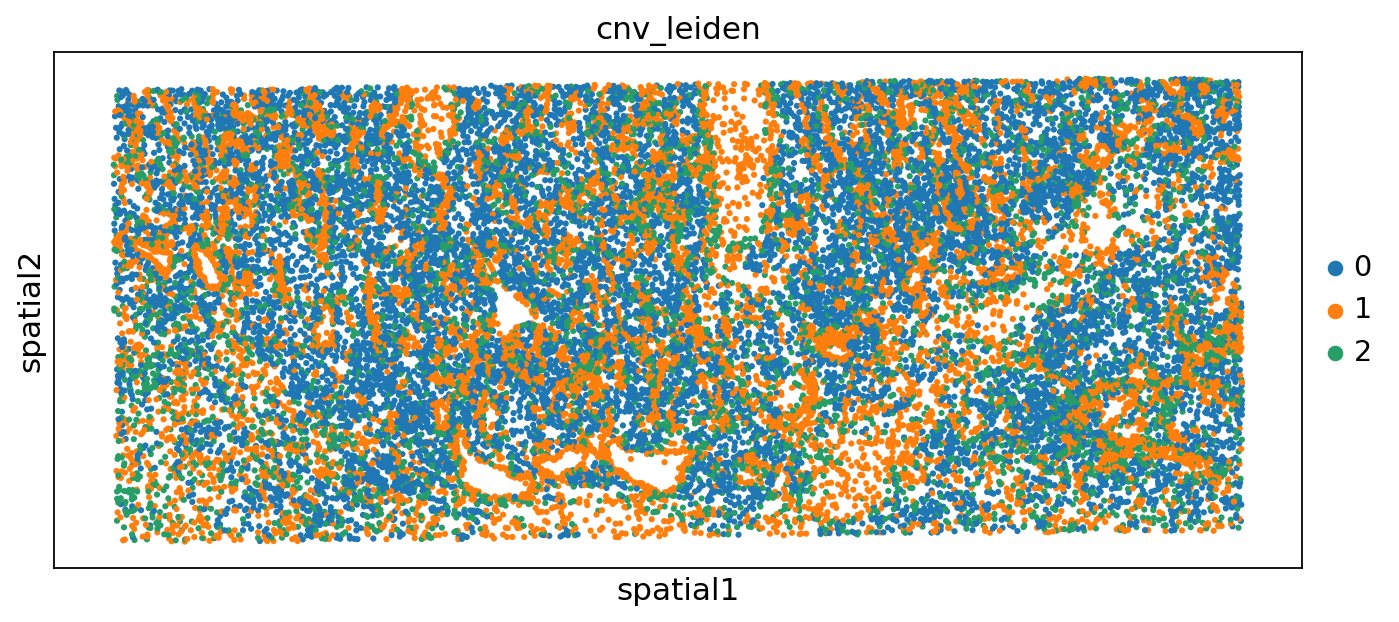

In [94]:
sc.pl.spatial(adata,color='cnv_leiden',spot_size=20)

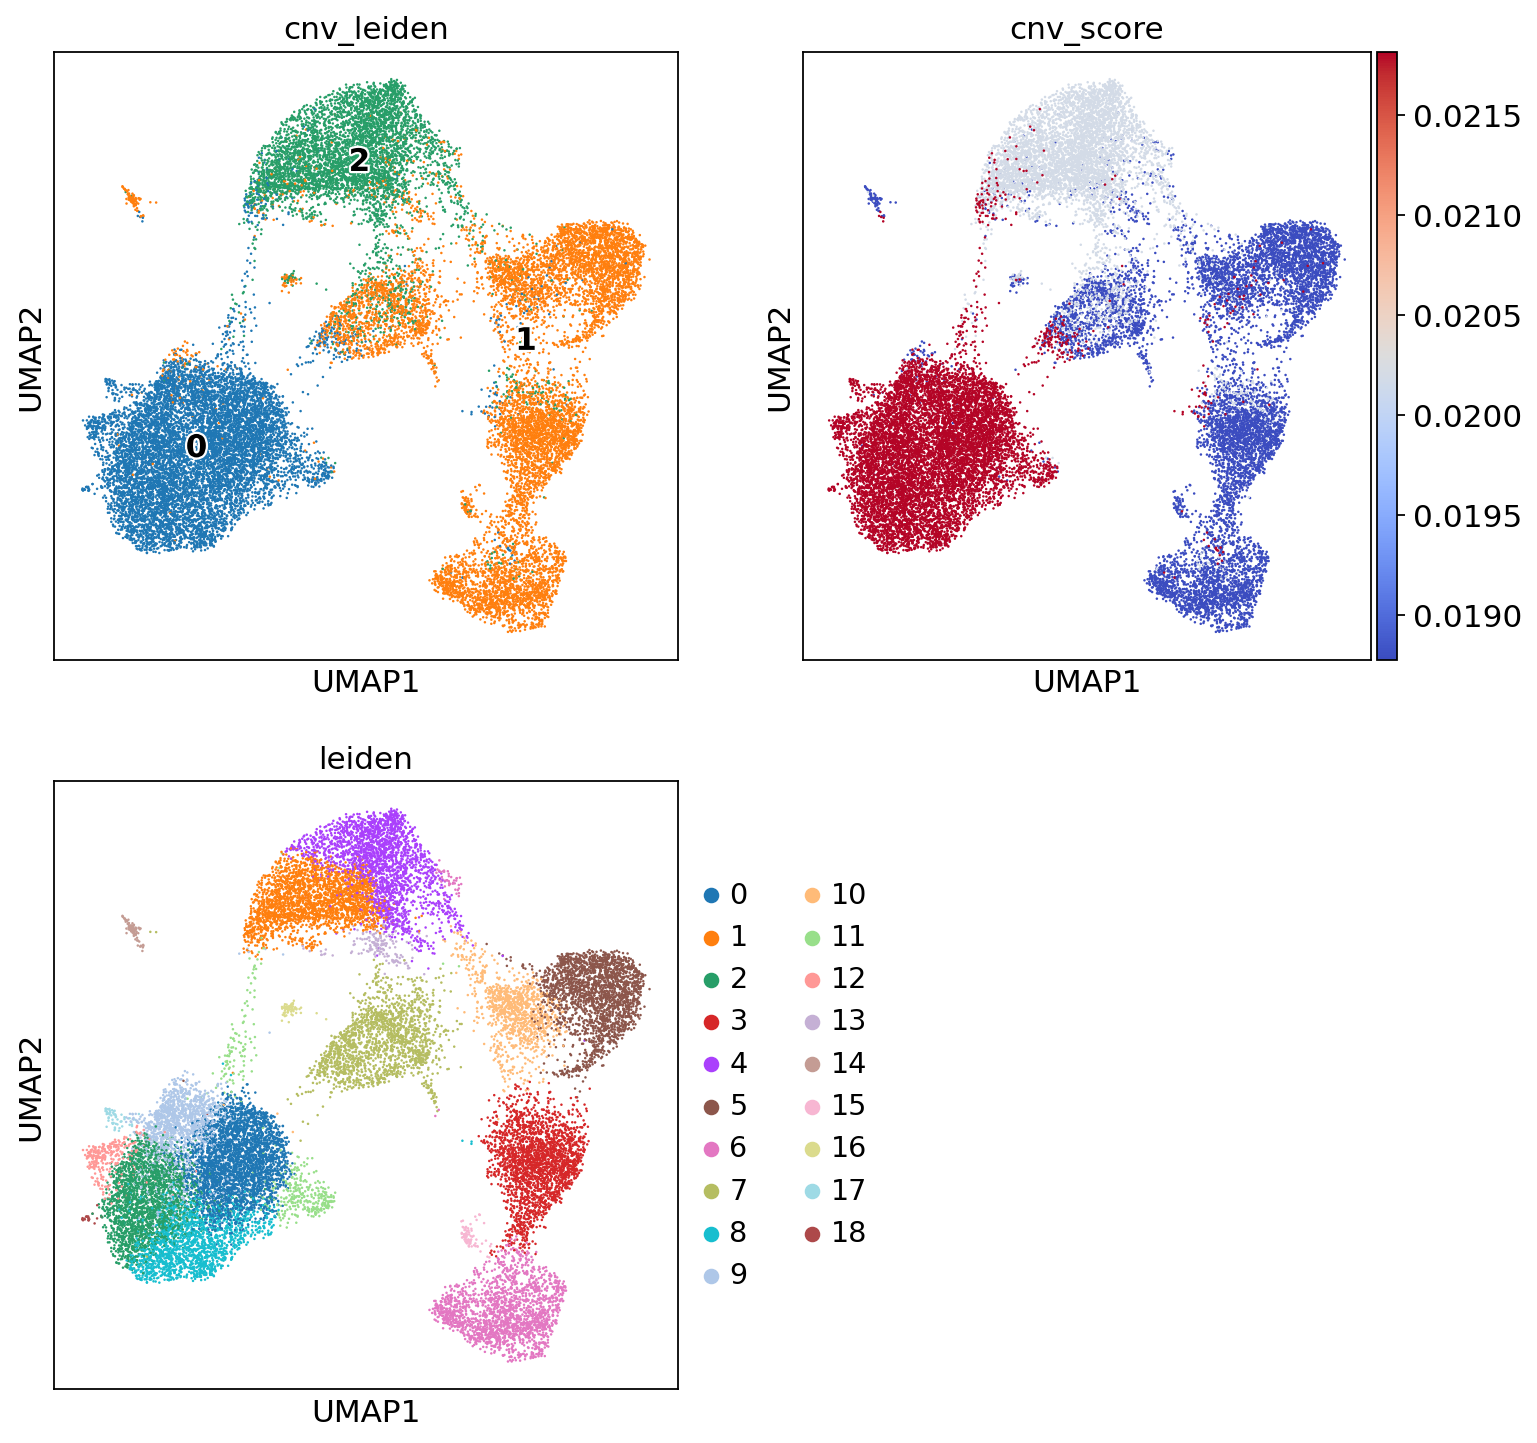

In [95]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")
sc.pl.umap(
    adata,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,cmap='tab20'
)
sc.pl.umap(adata, color="cnv_score", ax=ax2, show=False,cmap='coolwarm')
sc.pl.umap(adata, color="leiden", ax=ax3,cmap='tab20b')

In [96]:
adata.write('/media/sergio/GBX/xenium_prerelease_nov23_5k_v2/pipeline_output_5000Kkidney/combined_with_csv.h5ad')